# Problem B1: First autocorrelation inequality
For any function $f:\mathbb{R} \rightarrow \mathbb{R}$, define the *autoconvolution* of $f$, written $f*f$, as
$$f*f (t) := \int_\mathbb{R} f(t-x) f(x)\ dx.$$

Let $C_1$ denote the largest constant for which one has
\begin{equation}
 \max_{-1/2 \leq t \leq 1/2} f*f(t) \geq C_1 \left(\int_{-1/4}^{1/4} f(x)\ dx\right)^2
\end{equation}
for all non-negative $f: \mathbb{R} \rightarrow \mathbb{R}$.  This problem arises in additive combinatorics, relating to the size of Sidon sets.  It is currently known that
$$ 1.28 \leq C_1 \leq 1.5098$$
with the lower bound proven by [Cloninger and Steinerberger (2017)](https://www.ams.org/journals/proc/2017-145-08/S0002-9939-2017-13690-9/S0002-9939-2017-13690-9.pdf) and the upper bound achieved by [Matolcsi and Vinuesa (2010)](https://www.sciencedirect.com/science/article/pii/S0022247X10006001) via a step function construction. AlphaEvolve found a step function with 600 equally-spaced intervals on $[-1/4,1/4]$ that gives a better upper bound of $C_1 \leq 1.5053$.

In [4]:
height_params_google = torch.tensor([9.00854017233134, 4.581788824134047, 5.954983797866223, 3.7314786029786324, 4.25817159660483, 3.544987049547799, 0.08876194700959494, 0.0491697316439318, 1.7439263266999894, 3.8548164683263795, 3.621038728073569, 4.04587668218835, 4.68211946529981, 5.5904236142896675, 4.737832747546433, 3.1594093823451055, 1.902874129984629, 2.7870307391136304, 3.277574995692391, 1.8981329099596054, 1.526040859367755, 2.305128838504833, 5.17673786436095, 4.583218228762042, 3.9910761392791887, 2.784600928752006, 5.450687602543662, 6.170368723277989, 7.045569321986071e-16, 7.149948549556939e-15, 0.0, 0.0, 0.0, 0.0, 1.2580295353835013e-15, 0.0, 0.0, 0.0, 0.0, 3.873037303627252e-15, 0.0, 0.0, 2.020385656008168e-06, 0.000293922119342568, 0.0, 4.9514916125368726e-15, 7.282654612521097e-16, 1.906059354629418e-14, 0.0, 3.3528418595404916e-15, 1.5099558045700925e-15, 4.901439953827422e-15, 0.0, 8.851999542886555e-15, 0.0, 0.0, 0.0005211322699854395, 0.3757576289315001, 0.25176470069965495, 4.1179587840945515e-06, 0.0, 2.946431316197597e-15, 0.0, 1.0333089131925899e-16, 2.591940622467849e-15, 0.0, 6.852171628124262e-15, 0.0, 0.0, 1.3885601200927435e-14, 2.5015636739088256e-15, 1.4382184696274247e-14, 1.235388698636516e-15, 9.328196456283097e-15, 6.938490364750181e-15, 5.581796597296351e-17, 0.0, 0.0, 5.1220388613389905e-15, 0.0, 6.085199919293191e-15, 0.0, 0.0, 1.0633201915504476e-14, 6.240893078396387e-16, 0.0, 9.242385301100576e-15, 2.1818685641605435e-15, 0.0, 3.841626602268906e-15, 0.0013592097228050644, 8.120066974555713e-15, 8.479388423870961e-16, 2.5924005380166956e-15, 0.0, 2.6610672065525727e-15, 0.0, 1.233819156251431e-14, 8.819083406210366e-15, 0.0, 4.492323424835768e-16, 0.0, 3.0916450306058138e-15, 0.0, 0.0, 3.404186949211756e-15, 4.54126650881379e-15, 1.462631558763152e-14, 0.0, 0.0, 0.0, 1.4460597710909072e-15, 9.521734973996671e-15, 0.0, 4.559858799705722e-15, 7.864867909828807e-16, 0.0, 1.7856864350178655e-16, 0.00021045010164189585, 0.26541232693216404, 0.8094426381528257, 0.5750041584597478, 0.23313281323505236, 3.6007277514467585e-05, 0.0, 0.7828826491881691, 0.43382874037802, 1.3263698571911402, 0.5441713262465393, 0.9864380574571914, 0.6776516652004773, 0.5910950602641856, 0.507419190418916, 0.5231329501406576, 0.9391246115133585, 0.4508771959372286, 0.28283039994676146, 1.2889986480406397, 0.9649046182943108, 1.4104382244415803, 1.3916682358533747, 0.8743196646011149, 0.7627485335443527, 0.2103862254578538, 0.14545209168646947, 0.019762475547189184, 1.2279396984729254, 0.012006361768949678, 1.7677675926679783, 0.9303739918691369, 1.0966313889580412, 0.40142701455261154, 0.1477985748190306, 0.1310850821272394, 0.0027642064206369592, 0.6718883532064702, 0.287789791442545, 1.1886491680958895, 0.6459736548490735, 0.88966666001013, 0.36931312374260505, 0.6840914190936884, 0.38692129734520775, 0.8050006872194091, 0.26610729268169875, 0.002941709304056364, 0.5150673486621109, 0.4049854152265144, 1.1607178193685956, 1.7547854228356075, 0.0, 0.8531817250969695, 2.3845552035650363e-05, 0.035208188035124974, 0.06799207369201249, 0.14050016250524128, 0.4862562534194792, 1.508781726996261, 0.46943710673489225, 0.22962993226722195, 1.589825945710927e-11, 3.51517770993058e-15, 2.4398590319680178e-15, 1.1666504235544564e-06, 0.0021946672216711, 0.34171503722540436, 0.4703022197366691, 0.1313974666218601, 0.11754826815054241, 0.0, 2.2387234387833643e-16, 0.0, 7.192783695625604e-05, 0.4486935802226264, 1.234691190028419, 2.8985055264499153, 1.0234017394012231, 2.7375379465420373, 0.5899927642043619, 1.4461499611411766, 0.7033498408537826, 1.6505029216035125, 0.9593634797752735, 0.009302210703764222, 0.0004181359389419785, 0.0, 0.0, 0.0023430720926212976, 0.42801036705183393, 0.6031743194865573, 1.8862845950884395, 1.0944504439060767, 1.3978223736063145, 0.13603422891356853, 0.8568768273359568, 0.5287328963079988, 0.04201038853661816, 0.5746932650501643, 0.7698787794362285, 2.2478052766496255, 1.3267115762262056, 1.3819155415467284, 1.210307904386098, 1.2050374056121944, 0.973960636675429, 0.13506178694552, 0.0017211602091930576, 1.2080793667302383, 0.9431703684918005, 0.004927152124127672, 0.26457949335968395, 0.219096730428291, 0.8972094379125464, 1.009247390062118, 2.5396761105116816, 2.0567929964131704, 2.5384945885180765, 2.051772820060434, 2.841483226472209, 2.5484575236736253, 2.900405077014117, 2.7293223781158513, 2.8016507480694623, 2.5235338506952227, 2.842495616436774, 3.6113040879253218, 2.4409992918997654, 2.8613737519007785, 2.0376653653073236, 2.873716631081072, 2.7431139992026585, 2.3176851657187343, 2.963845077577065, 2.1297112056154828, 3.1281786712157276, 1.559962066888169, 1.5175735153572592, 1.8986372289826554, 2.422172211485286, 1.4024751115172904, 1.6645681102200025, 1.0890488631004245, 0.9551468779062758, 0.4210663124027455, 0.7844656815643463, 1.3849725648239561, 1.1400002207678432, 1.2589535564861496, 0.00010847583255872839, 0.33022246693439483, 0.009991411612394792, 3.897603693807049e-14, 0.0, 0.0, 4.615098985648224e-16, 0.0, 0.0, 0.00019552451607645426, 7.535959259635103e-15, 0.0, 0.0, 0.0, 3.391322478636254e-15, 0.0, 5.23262076392476e-16, 0.0, 0.0013138779575907105, 3.8754445450268335e-05, 0.6732744675805906, 0.1403000505612687, 0.1066587972153134, 3.248799681911591e-05, 0.0002955183459383166, 0.003362359949825627, 1.258993392593319, 0.6721840514813638, 1.4023077519116312, 0.26971646568749497, 1.5317811712427716e-06, 0.0, 0.0004643255998670316, 0.21977013225378167, 0.4192480303816599, 1.5193826730071023, 1.140986767032434e-14, 0.00023172541086911792, 0.0, 2.8126101180648514e-16, 0.3250641832764737, 0.2631639184319745, 9.581064115586714e-06, 6.911241239536039e-08, 2.1977413193942923e-15, 0.0, 0.009284626840990289, 0.38181362260215157, 0.9229241174303233, 1.2389265199825776, 4.003701357117134e-15, 0.0018347819223694948, 0.09741977675536181, 0.7177732728524777, 0.893918190086622, 0.7592094697415344, 0.33941833076021116, 0.9895237780462212, 1.2103201657651075, 0.1562357060123791, 0.05779942219135546, 0.046035988201598356, 0.20605598834789451, 0.7087789468745198, 0.9835248618606901, 0.15343068950958472, 0.7458575667928422, 1.1650897270704061, 0.8603305066335794, 0.21035575411632462, 0.1359607526732069, 0.27083984880209855, 0.6401471037748572, 3.021195033008772e-11, 0.2302514662496976, 0.6133656015904811, 0.0014526177283533382, 0.2833008515927792, 0.6173666814379335, 0.35174441102605253, 0.42994053621927014, 0.17019592622467353, 0.18730260272562482, 0.20732692125660646, 0.0006488239072035948, 0.0008689690193708769, 0.0060827028748053225, 0.42803050608386095, 0.5802023431307022, 0.07735146147149399, 0.2677857202504946, 0.0009184606747345728, 0.43037124020293993, 0.3617534843366182, 0.3772422594534307, 0.2584947755294139, 0.001169636807952639, 1.9643151751270573e-08, 0.0, 0.0, 0.0, 2.0182994696828576e-15, 0.06977916421885891, 0.2579938169821856, 0.37671532887212333, 0.024565028057913885, 0.12617825469188657, 0.6340448467030686, 0.5754643941945634, 0.13048109721771595, 1.4341543078480776, 1.3216214397106167, 0.4415648326891368, 0.8216927039920507, 0.9032727935119587, 1.7656705299211204, 1.627512140396068, 1.5918752695978569, 2.051239519025683, 1.9657798505455604, 2.8356702084496526, 2.5590427999121284, 2.982526516926714, 2.6272105137933197, 2.960027241401188, 3.3362990605756897, 3.131536821850587, 3.159111523746814, 2.7752077904104517, 1.0508812833436538, 0.21463498939778325, 0.6073490769165661, 0.267278502966685, 0.3440305423365897, 1.0124744653679076, 1.342256457731422, 0.2717826360960419, 1.6632114845610049, 1.7120322558818795, 1.575579186781418, 2.202279058543633, 2.005531691208538, 1.891973046186819, 2.2982791457282916, 2.4252951011748562, 1.3467523990450576, 1.394123734140854, 1.306121994024973, 1.3563331357893305, 1.908587215779497, 2.2410142807813824, 2.1400334226110425, 2.0238641943935187, 2.4448713165408282, 0.001517101822563153, 9.482987339023494e-15, 0.0, 1.5827373963789938e-15, 1.580023867552888, 2.5839838573569534, 1.5871346370389885, 4.1337617125689725, 0.0016876790012300346, 2.337637442823331, 1.9268402331708496, 2.509223443618991, 2.8573979857307554, 2.7429627532040692, 2.3184117402885605, 2.2519888495692886, 1.441733890843454, 2.3283267069330638, 2.090507069768287, 1.616388780668859, 0.30852077577914405, 1.2418308849676503, 0.749579822648432, 2.0216862557918627, 1.8471265276557536, 1.9409844374088654, 2.029630658555306, 1.7488835640200255, 1.4429217698293368, 0.09853693097516952, 1.5685094105495399, 0.060035092997817674, 1.1562109869575399, 0.9883011451997243, 1.257630809337659, 1.6997562951967606, 0.4508041502784602, 0.3164090446061367, 1.4182969827012353, 1.3595162629204571, 1.475081471520821, 3.021289456736385, 3.0956206508951407, 2.481681959913101, 2.1308362149915583, 2.9008847410243757, 2.909122424144527, 2.7204695218309363, 2.087469496170989, 1.3538856364999683, 0.2008306196121235, 1.600964614957816, 1.4250387287265247, 1.6911311698607534, 1.1526705582269934, 0.7292975452608408, 0.4173852602091413, 0.2662677349829448, 1.5122097133171966, 1.0836674077065491, 1.031414686946613, 0.8173974802808452, 0.7095506482976092, 0.5949976898998941, 0.29670773819783247, 0.5083829941296425, 0.6440505445429058, 0.053833868680306, 7.794970013943188e-16, 0.7045208512938965, 1.6120699276991068, 1.5318231382310976, 1.7340273755678486, 2.4381603392169247, 2.6170276892155027, 2.5906147953962844, 3.407886846404895, 3.6212633825479905, 2.329416094716585, 2.958660792491976, 2.6669305434977773, 2.1590860132417564, 2.4937418622856145, 2.5589089762124786, 1.3338118137548678, 1.1942787402156965, 1.7418035300505763, 1.4081188229888932, 1.2487225960375548, 1.4492676314261193, 1.2654783371285574, 1.1685912162797853, 1.0148303874944786, 1.1962440020710763, 1.305708313372589, 0.6602148155530632, 0.337166044389861, 0.8396055147211476, 0.8562349502018103, 0.588778548048956, 0.7049070769530035, 1.2538977263308646, 1.4831897704424597, 1.4593441911500031, 2.1621717599542505, 2.4273857543891015, 2.426355640271325, 2.83832034285733, 2.7641303296460444, 2.2050969080359004, 2.6355562577584215, 3.1005626046243817, 2.4089187966341488, 1.8919645338161346, 1.8840157076492403, 1.344761629829863, 1.404294123950026, 1.8721961393692923, 1.3226408636613955, 0.4215497636181964, 0.5726863357586803, 1.0258923965461795, 1.1819610363504558, 0.8368490648663582, 0.6515561348082733, 0.6685731745760881, 0.5334870649826413, 0.8710519187832059, 0.6669646197224997, 0.5260752114304805, 0.3876797985565807, 0.03621327582895155, 0.46897871650384915, 0.8718533580569904, 0.7009452451531725, 1.4931853849244896, 1.8652719440498333, 1.6631794982365034, 1.494779190512575, 2.508688004725345, 3.0433643835464537, 3.2533878501144433, 3.579790260747532, 2.164640103097207, 0.6698924809914789, 2.1342050222506663, 2.5814605344559984, 1.6583152357630657, 1.3111552900920307, 1.20851491437197, 0.3334479204279151, 0.0027238985981172218, 0.7485037657977041, 0.23706880539492062, 0.3990097623354095, 4.751136081369487e-05, 1.5362095500430528, 0.46926869783190056, 0.0007246232360620678, 0.0, 5.239717734593537e-16, 9.938359637204445e-16, 0.0, 1.7385067095755083e-16, 4.106727240038999e-15, 0.10511094949367368, 0.026846967487429776, 0.0796163088839284, 0.8797518497354565, 2.616397453997683, 3.9912371044774604, 3.6233174077890604, 1.5672138389164023, 1.8304904251881515, 2.748948532497653, 3.287747311072218, 4.0926517829783675, 6.029811160308903])

# Normalize to the simplex because we'll be doing this later anyway
height_params_google = (1200)*height_params_google / (torch.sum(height_params_google))
height_params_google.requires_grad = True


## Compute the step function, the integral, and the autoconvolution

In [1]:
import torch
import torch.nn.functional as F

# Step function representation:
# The step function f is implicitly defined by:
# - heights: a 1D tensor of P non-negative values h_i.
# - P: number of pieces.
# - interval_range: a tuple (x_min, x_max), e.g., (-0.25, 0.25).
# - delta_x: width of each piece, (x_max - x_min) / P.
# - x_coords: tensor of starting x-coordinates for each piece.
# For optimization, 'heights' would be your learnable parameters.
#
# Example of how you might define these:
# P = 600
# interval_range = (-0.25, 0.25)
# heights = torch.rand(P, dtype=torch.float64, requires_grad=True) # example heights
# delta_x = (interval_range[1] - interval_range[0]) / P
# x_min = interval_range[0]

def compute_integral_of_step_function(heights: torch.Tensor, delta_x: float) -> torch.Tensor:
    """
    Computes the integral of the step function f(x)dx.
    f(x) is defined by `heights` h_i over pieces of width `delta_x`.
    Integral = delta_x * sum(h_i).
    """
    if not torch.all(heights >= 0):
        # print("warning: heights should be non-negative for the problem context.")
        # depending on your optimization strategy, you might enforce this elsewhere (e.g. h_i = relu(alpha_i))
        pass # up to you how strict to be here, problem says "non-negative f"
    return delta_x * torch.sum(heights)

def compute_autoconvolution_values(heights: torch.Tensor, delta_x: float, P: int) -> torch.Tensor:
    """
    Computes the values of the autoconvolution (f*f)(t) at the knot points.
    (f*f)(t) is piecewise linear. Max value occurs at one of these knots.
    Knots are t_m = 2*x_min + m*delta_x for m = 0, ..., 2P.
    Values are [0, delta_x * (H*H)_0, ..., delta_x * (H*H)_{2P-2}, 0].
    (H*H) is the discrete convolution of the height sequence H.
    """
    # Ensure heights is 1D
    if heights.ndim != 1 or heights.shape[0] != P:
        raise ValueError(f"heights tensor must be 1D with length P={P}. Got shape {heights.shape}")

    # Reshape heights for conv1d: (batch_size, C_in, L_in)
    # batch_size=1, C_in=1
    h_signal = heights.view(1, 1, P)
    
    # The kernel for conv1d to compute (H*H) should be H flipped.
    # weight for conv1d: (C_out, C_in/groups, L_kernel)
    # C_out=1, C_in/groups=1
    h_kernel_flipped = torch.flip(heights, dims=[0]).view(1, 1, P)

    # Compute H*H using conv1d. Padding P-1 results in output length 2P-1.
    # These are (H*H)_0, ..., (H*H)_{2P-2}
    conv_result = F.conv1d(h_signal, h_kernel_flipped, padding=P-1).squeeze()
    
    # Scale by delta_x
    conv_scaled = delta_x * conv_result
    
    # Add zeros for (f*f)(t_0) and (f*f)(t_{2P})
    zero = torch.tensor([0.0], device=heights.device, dtype=heights.dtype)
    autoconvolution_knot_values = torch.cat([zero, conv_scaled, zero])
    
    return autoconvolution_knot_values


## Plot the step function and the autoconvolution

--- Function Details (P=600) ---
Integral of f(x): 0.239110
Max value of autoconvolution (f*f)(t): 0.118496
Ratio max(f*f) / (integral(f))^2: 2.072562


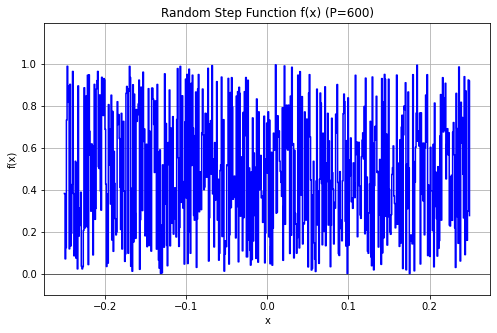

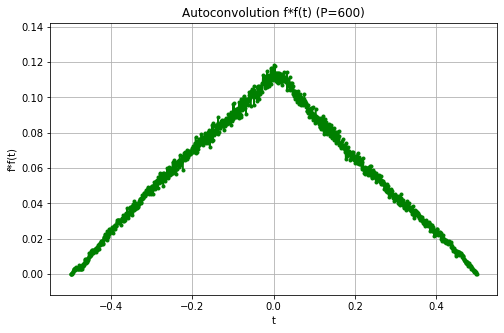

In [2]:
# script assumes 'compute_integral_of_step_function' and 'compute_autoconvolution_values'
# (from your previous code block) are already defined and executable in the notebook.

#@title Imports and Plotting Setup
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- plotting functions ---
def plot_rendered_step_function(heights_numpy: np.ndarray, interval: tuple[float, float], title=""):
    """plots a step function f(x) cleanly using plt.step."""
    P = len(heights_numpy)
    x_min, x_max = interval
    
    step_edges = np.linspace(x_min, x_max, P + 1, dtype=float) # ensure float for plotting
    
    plt.figure(figsize=(8, 5))
    plt.step(step_edges[:-1], heights_numpy, where='post', color='blue', linewidth=1.5)
    
    plt.axhline(0, color='black', linewidth=0.5) # reference line at y=0
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title(title)
    
    # dynamic axis limits
    x_padding = 0.05 * (x_max - x_min) if (x_max - x_min) > 0 else 0.05
    plt.xlim([x_min - x_padding, x_max + x_padding])
    
    if P > 0:
        max_h = np.max(heights_numpy)
        min_h = np.min(heights_numpy) # relevant if heights could be negative
        if max_h > 0: # typical case for non-negative heights
            plt.ylim([-0.1 * max_h, max_h * 1.2])
        elif max_h == 0 and min_h == 0 : # all zero heights
            plt.ylim([-0.5, 0.5])
        else: # other cases (e.g. all negative, not expected here)
            plt.ylim([min_h - 0.1*abs(min_h), max_h + 0.1*abs(max_h)])

    else: # P=0, no data
        plt.ylim([-0.5, 1.0]) 
        
    plt.grid(True)
    plt.show()

def plot_rendered_convolution(t_values_numpy: np.ndarray, conv_values_numpy: np.ndarray, title=""):
    """plots a piecewise linear function, e.g., the autoconvolution f*f(t)."""
    plt.figure(figsize=(8, 5))
    plt.plot(t_values_numpy, conv_values_numpy, marker='o', linestyle='-', color='green', markersize=3, linewidth=1.5)
    
    plt.xlabel("t")
    plt.ylabel("f*f(t)")
    plt.title(title)
    
    if len(t_values_numpy) > 0:
        t_min, t_max = t_values_numpy[0], t_values_numpy[-1]
        t_padding = 0.05 * (t_max - t_min) if (t_max - t_min) > 0 else 0.05
        plt.xlim([t_min - t_padding, t_max + t_padding])
        
        max_conv = np.max(conv_values_numpy)
        min_conv = np.min(conv_values_numpy)
        # autoconvolution of non-negative f(x) is non-negative
        if max_conv > 0:
            plt.ylim([-0.1 * max_conv, max_conv * 1.2])
        else: # all zero (or P=0 for f(x))
            plt.ylim([-0.5, 0.5])
    else: # no data
        plt.xlim([-0.55, 0.55]) # default based on expected autoconv range
        plt.ylim([-0.1, 1.0])
        
    plt.grid(True)
    plt.show()

# --- main script logic ---
P_val = 600  # number of pieces for the step function
f_interval = (-0.25, 0.25) # interval for f(x)

f_x_min, f_x_max = f_interval
f_delta_x = (f_x_max - f_x_min) / P_val

# 1. sample random heights (non-negative)
# using float64 for precision, requires_grad=False for plotting/evaluation only
height_values = torch.rand(P_val, dtype=torch.float64) 
# for more structured/sparse functions, you could try:
# height_values = torch.abs(torch.randn(P_val, dtype=torch.float64)) * (torch.rand(P_val, dtype=torch.float64) > 0.7).double()


# 2. compute integral of f(x)
integral_value = compute_integral_of_step_function(height_values, f_delta_x)

# 3. compute autoconvolution (f*f)(t) knot values
# (2*P_val + 1) values for t_m from 2*f_x_min to 2*f_x_max
autoconv_knot_vals = compute_autoconvolution_values(height_values, f_delta_x, P_val)
max_autoconv_value = torch.max(autoconv_knot_vals)

# 4. calculate the ratio for C1 estimate
# (max f*f(t)) / (integral f(x) dx)^2
if integral_value.item() == 0:
    c1_ratio = float('inf') if max_autoconv_value.item() > 0 else 0.0 # handle division by zero
else:
    c1_ratio = max_autoconv_value / (integral_value**2)

print(f"--- Function Details (P={P_val}) ---")
# print(f"Heights (h_i, first 10): {height_values.numpy()[:10]}") # uncomment if you want to see heights
print(f"Integral of f(x): {integral_value.item():.6f}")
print(f"Max value of autoconvolution (f*f)(t): {max_autoconv_value.item():.6f}")
print(f"Ratio max(f*f) / (integral(f))^2: {c1_ratio.item():.6f}")


# 5. plotting
# plot f(x)
plot_rendered_step_function(height_values.numpy(), f_interval, title=f"Random Step Function f(x) (P={P_val})")

# plot f*f(t)
# autoconvolution is defined on [2*f_x_min, 2*f_x_max]
conv_t_knots = np.linspace(2 * f_x_min, 2 * f_x_max, 2 * P_val + 1, dtype=float)
plot_rendered_convolution(conv_t_knots, autoconv_knot_vals.numpy(), title=f"Autoconvolution f*f(t) (P={P_val})")



## Plotting Google's solution

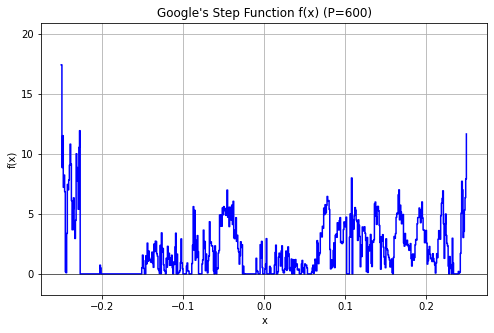

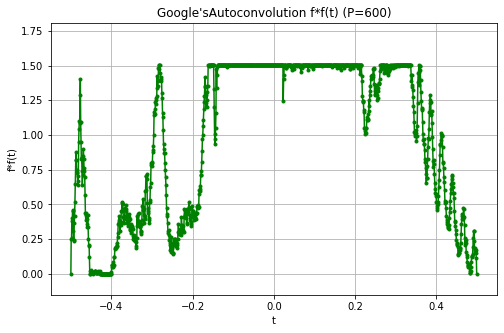

In [14]:
# Also plot google's solution
autoconv_knot_vals_google = compute_autoconvolution_values(height_params_google, f_delta_x, P_val)
max_autoconv_value_google = torch.max(autoconv_knot_vals_google)

plot_rendered_step_function(height_params_google.detach().numpy(), f_interval, title=f"Google's Step Function f(x) (P={P_val})")
plot_rendered_convolution(conv_t_knots, autoconv_knot_vals_google.detach().numpy(), title=f"Google'sAutoconvolution f*f(t) (P={P_val})")

## Projection onto the simplex

In [15]:
import torch

def projection_simplex_pytorch(v: torch.Tensor, z: float = 1.0) -> torch.Tensor:
    n_features = v.shape[0]
    if n_features == 0:
        return torch.empty_like(v)
    u, _ = torch.sort(v, descending=True)
    cssv_minus_z = torch.cumsum(u, dim=0) - z
    ind = torch.arange(1, n_features + 1, device=v.device) 
    cond = u - cssv_minus_z / ind > 0
    true_indices = torch.where(cond)[0]
    rho_idx = true_indices[-1] 
    rho = ind[rho_idx] 
    theta = cssv_minus_z[rho_idx] / rho 
    w = torch.clamp(v - theta, min=0.0)
    return w

# test the function
v = torch.tensor([1.0, 2.0, 3.0])
z = 100
w = projection_simplex_pytorch(v, z)
print("w", w, "sum(w)", sum(w))



w tensor([32.3333, 33.3333, 34.3333]) sum(w) tensor(100.0000)


## Set up parameters, loss function, and compute the gradient

In [16]:
# Setting function parameters
P_val = 600  # number of pieces for the step function
f_interval = (-0.25, 0.25) # interval for f(x)

f_x_min, f_x_max = f_interval
f_delta_x = (f_x_max - f_x_min) / P_val

# Define optimization variable
height_params = torch.rand(P_val, dtype=torch.float64)
height_params.requires_grad = True

def loss_fn(h): 
    max_f_conv_f_values_at_knots = compute_autoconvolution_values(h, f_delta_x, P_val)
    return max_f_conv_f_values_at_knots.max()

# Project variables onto the simplex 
with torch.no_grad():
    height_params.data = projection_simplex_pytorch(height_params.data, 2*P_val)

# Compute loss and gradient at a random point.
loss = loss_fn(height_params)
print("loss", loss.item())
grad = torch.autograd.grad(loss, height_params)[0]

# Compute loss and gradient at Google's solution
loss_google = loss_fn(height_params_google)
print("loss_google", loss_google.item())
grad_google = torch.autograd.grad(loss_google, height_params_google)[0]



loss 1.9982970769344686
loss_google 1.5052945613861084


## Algorithm 1: (Projected) Polyak subgradient method

The algorithm 
$$
h_+ = \mathrm{proj}_{\Delta_{2P}}\left(h - \frac{L(h) - L^*}{\| \nabla L(h) \|^2} \nabla L(h)\right)
$$
where $L^*$ is the target loss.

There is a subtlety here: we don't know what the optimal value is.

### Random initialization

Starting Polyak subgradient method
Iteration 0: loss = 1.998297, step_size = 72.469661, min_loss_found_polyak = inf
Iteration 100: loss = 1.641134, step_size = 17.945998, min_loss_found_polyak = 1.637867
Iteration 200: loss = 1.641542, step_size = 15.236543, min_loss_found_polyak = 1.614287
Iteration 300: loss = 1.612236, step_size = 11.485510, min_loss_found_polyak = 1.598467
Iteration 400: loss = 1.578687, step_size = 8.232086, min_loss_found_polyak = 1.578216
Iteration 500: loss = 1.561186, step_size = 8.877935, min_loss_found_polyak = 1.563043
Iteration 600: loss = 1.571202, step_size = 8.129110, min_loss_found_polyak = 1.556314
Iteration 700: loss = 1.557696, step_size = 5.182911, min_loss_found_polyak = 1.556314
Iteration 800: loss = 1.558598, step_size = 8.107446, min_loss_found_polyak = 1.553789
Iteration 900: loss = 1.559862, step_size = 6.574282, min_loss_found_polyak = 1.551844
Iteration 1000: loss = 1.554589, step_size = 4.857536, min_loss_found_polyak = 1.551844
Iteration 

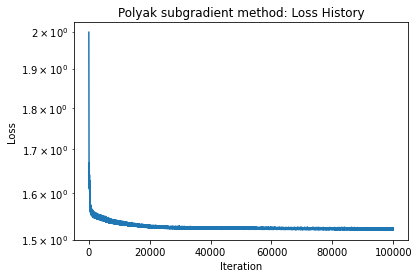

In [17]:
def polyak_subgradient_method(h_params, loss_fn, max_iter=100000, target_loss=1.5053, print_every=100, loss_history_polyak=[], min_loss_found_polyak=float('inf'), best_height_params_polyak=height_params.data.clone()):
    for i in range(max_iter):
        # Compute loss and gradient
        h_params.grad = None
        loss = loss_fn(h_params)
        grad = torch.autograd.grad(loss, h_params)[0]

        grad_norm_squared = torch.norm(grad)**2
        
        step_size = torch.clamp((loss.item() - target_loss) / grad_norm_squared, min=0.0)
        h_params.data -= step_size * grad

        # Project onto the simplex
        with torch.no_grad():
            h_params.data = projection_simplex_pytorch(h_params.data, 2*P_val)

        loss_history_polyak.append(loss.item())        
        if i % print_every == 0:
            print(f"Iteration {i}: loss = {loss.item():.6f}, step_size = {step_size:.6f}, min_loss_found_polyak = {min_loss_found_polyak:.6f}",)

        if loss.item() < min_loss_found_polyak:
            min_loss_found_polyak = loss.item()
            best_height_params_polyak = height_params_polyak.data.clone()
    return best_height_params_polyak, min_loss_found_polyak, loss_history_polyak


height_params_polyak = height_params.data.detach().clone() # initialize variable at value from test cell 
# height_params_polyak = height_params_google.data.detach().clone() # initialize variable at google's solution.
height_params_polyak.requires_grad = True

# if loss history exists, append to it
if 'loss_history_polyak' not in locals():
    loss_history_polyak = []
max_iter = 100000
target_loss = 1.50529
print_every = 100

if 'min_loss_found_polyak' not in locals():
    min_loss_found_polyak = float('inf')

if 'best_height_params_polyak' not in locals():
    best_height_params_polyak = height_params_polyak.data.clone()

print("Starting Polyak subgradient method")
best_height_params_polyak, min_loss_found_polyak, loss_history_polyak = polyak_subgradient_method(height_params_polyak, loss_fn, max_iter, target_loss, print_every, loss_history_polyak, min_loss_found_polyak, best_height_params_polyak)

print("Final loss:", loss.item())

# semilogy plot of loss history
plt.semilogy(loss_history_polyak)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Polyak subgradient method: Loss History")
plt.show()
